In [1]:
%load_ext tensorboard

In [2]:
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
import numpy as np, scipy as sp, scipy.stats, os, sys, joblib
import os, numpy as np, scipy as sp, scipy.io, scipy.io.wavfile
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score
from sklearn.utils import class_weight
import random
import pandas as pd
import importlib
import datetime
import useful_functions
import preprocessing_functions
import Chatgpt_model
import results_functions
import metrics_loss_functions
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-07-24 15:40:20.800336: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-24 15:40:20.820890: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 15:40:21.167071: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


2023-07-24 15:40:22.550390: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-24 15:40:22.550918: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-24 15:40:22.550973: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
importlib.reload(useful_functions)
importlib.reload(preprocessing_functions)
importlib.reload(Chatgpt_model)
from useful_functions import *
from preprocessing_functions import *
from Chatgpt_model import *

In [4]:
 # Define the data and model foldes.
data_folder = r"../training_data"
model_folder = r"../model"
wind_size = 6000
verbose = 3

In [5]:
recordings,patient_label,patient_id = create_rec_patient_list(data_folder)
df = build_dataset_df(recordings,patient_id,patient_label,wind_size)
df.head()

,patient_id,recording_type,recording,murmur
0,2530.0,1.0,"[254.62053374948147, 332.41397606699405, -727....",0.0
1,2530.0,1.0,"[20.550841480663475, -18.884669077279337, 152....",0.0
2,2530.0,1.0,"[2296.0082592261, 1161.8953810714854, 106.9764...",0.0
3,2530.0,1.0,"[-1.2132347511973676, -24.042684343382245, -14...",0.0
4,2530.0,1.0,"[219.40892010033423, 106.21377642082071, 296.9...",0.0


In [6]:
# check correctness of dataframe loaded
for i in range(df.shape[0]):
  if len(df["recording"][i]) != wind_size:
    print("problem sir")

In [7]:
# select only two columns
new_df = df[['patient_id', 'murmur']]
new_df = new_df.drop_duplicates()
new_df = new_df.reset_index(drop=True)

In [8]:
# check murmur/non-murmur balance
nb_murmur_present = (new_df.loc[new_df['murmur'] == 1]).shape[0]
nb_murmur_absent = (new_df.loc[new_df['murmur'] == 0]).shape[0]
print(nb_murmur_present)
print(nb_murmur_absent)

179
695


In [9]:
# display
new_df

,patient_id,murmur
0,2530.0,0.0
1,9979.0,1.0
2,13918.0,1.0
3,14241.0,1.0
4,14998.0,0.0
...,...,...
869,85340.0,0.0
870,85341.0,0.0
871,85343.0,1.0
872,85345.0,0.0


In [10]:
# complete list of distinct patient id's and corresponding label
list_id = new_df['patient_id'].to_list()
list_label = new_df['murmur'].to_list()


In [11]:
id_train, id_valtest, label_train, label_valtest = train_test_split(list_id, list_label , test_size=0.4, random_state=42)
id_val, id_test, label_val, label_test = train_test_split(id_valtest, label_valtest , test_size=0.5, random_state=42)


In [12]:
X = list(id_train) + list(id_val)
Y = list(label_train) + list(label_val)
X = np.array(X)
Y = np.array(Y)

In [13]:
def select_rows(id_list,dframe):
  #for id in list_id:
  sub_df = dframe.loc[dframe['patient_id'].isin([int(id) for id in id_list])]
  return sub_df

df_train = select_rows(id_train,df)
df_val = select_rows(id_val,df)
df_test = select_rows(id_test,df)
print(type(id_train))

<class 'list'>


In [14]:
print("Number of Murmur present : ",(df_train.loc[df_train['murmur'] == 1]).shape[0])
print("Number of Murmur absent : ",(df_train.loc[df_train['murmur'] == 0]).shape[0])

Number of Murmur present :  2697
Number of Murmur absent :  11832


In [15]:
X_train = np.vstack(df_train['recording'])
y_train = np.array(df_train['murmur'])

X_val = np.vstack(df_val['recording'])
y_val = np.array(df_val['murmur'])

X_test = np.vstack(df_test['recording'])
y_test = np.array(df_test['murmur'])

In [16]:
# concatenate X_train and X_val, y_train and y_val to keep same X_test,y_test as other  computations
X_train_CV = np.concatenate((X_train, X_val), axis=0)
#X_train_CV = np.concatenate((X_train_CV, X_test), axis=0)
print(X_train_CV.shape)
y_train_CV = np.concatenate((y_train, y_val), axis=0)
#y_train_CV = np.concatenate((y_train_CV, y_test), axis=0)
print(y_train_CV.shape)


(19358, 6000)
(19358,)


In [17]:
X_train_CV = X_train_CV.reshape(len(X_train_CV),len(X_train_CV[1]),1)
X_test = X_test.reshape(len(X_test),len(X_test[1]),1)

In [18]:
X_train_CV.shape

(19358, 6000, 1)

In [19]:
importlib.reload(Chatgpt_model)
from Chatgpt_model import *


In [20]:
weights = class_weight.compute_class_weight(  class_weight ='balanced',
                                    classes = np.unique(y_train_CV),
                                    y = y_train_CV)
class_weights = dict(zip(np.unique(y_train), weights))
class_weights
wghts = {0: 0.6139705882352942, 1: 2.693548387096774}


In [21]:
from sklearn.model_selection import KFold

importlib.reload(metrics_loss_functions)
from metrics_loss_functions import *

In [22]:
fscore = tf.keras.metrics.FBetaScore(beta=2.0,threshold=0.5, average='weighted')
auc = tf.keras.metrics.AUC(name='auc',curve='PR')

2023-07-24 15:40:40.669092: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-24 15:40:40.669313: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-24 15:40:40.669432: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [23]:
epochs = 100
batch_size = 32

preds10 = []

checkpoint_path = "checkpoint_dir/"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+ "_patience10_restoreTrue_val_avg"+"/"

kfold = KFold(n_splits=5, shuffle=True, random_state=11)

i = 1
for train_index, val_index in kfold.split(X,Y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = Y[train_index], Y[val_index]
    
    df_train = select_rows(X_train,df)
    df_val = select_rows(X_val,df)
    
    X_train = np.vstack(df_train['recording'])
    X_train = X_train.reshape(len(X_train),len(X_train[1]),1)
    y_train = np.array(df_train['murmur'])
    
    X_val = np.vstack(df_val['recording'])
    X_val = X_val.reshape(len(X_val),len(X_val[1]),1)
    y_val = np.array(df_val['murmur'])
    
    chckpnt_path = checkpoint_path+"M"+str(i)+"_cp.ckpt"
    checkpoint_dir = os.path.dirname(chckpnt_path)
    
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=chckpnt_path,
                                                 save_weights_only=True,
                                                 verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=10, min_lr=0.0001
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_avg", patience=10, verbose=1,restore_best_weights=True,mode='max'),
    tensorboard_callback,
    ]

    model = create_small_model(input_shape=X_train.shape[1:])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss="binary_crossentropy",
                  metrics=[Avg(),fscore,auc],
                  weighted_metrics = "acc")

    model.fit(X_train,
              np.array(y_train),
              batch_size=batch_size,
              epochs=epochs,
              callbacks=callbacks,
              class_weight=class_weights,
              validation_data=(X_val,np.array(y_val)),
              verbose=0)
    
    model.save_weights(checkpoint_path+"M"+str(i)+"_restored_weight"+"_cp.ckpt")
    y_pred = model.predict(X_test)
    preds10.append(y_pred)
    i = i+1


2023-07-24 03:29:52.313055: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-07-24 03:29:52.651916: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-24 03:29:52.968792: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f62e002ade0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-24 03:29:52.968804: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2023-07-24 03:29:52.971263: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-24 03:29:53.023877: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th


Epoch 1: saving model to checkpoint_dir/20230724-032938_patience10_restoreTrue_val_avg/M1_cp.ckpt

Epoch 2: saving model to checkpoint_dir/20230724-032938_patience10_restoreTrue_val_avg/M1_cp.ckpt

Epoch 3: saving model to checkpoint_dir/20230724-032938_patience10_restoreTrue_val_avg/M1_cp.ckpt

Epoch 4: saving model to checkpoint_dir/20230724-032938_patience10_restoreTrue_val_avg/M1_cp.ckpt

Epoch 5: saving model to checkpoint_dir/20230724-032938_patience10_restoreTrue_val_avg/M1_cp.ckpt

Epoch 6: saving model to checkpoint_dir/20230724-032938_patience10_restoreTrue_val_avg/M1_cp.ckpt

Epoch 7: saving model to checkpoint_dir/20230724-032938_patience10_restoreTrue_val_avg/M1_cp.ckpt

Epoch 8: saving model to checkpoint_dir/20230724-032938_patience10_restoreTrue_val_avg/M1_cp.ckpt

Epoch 9: saving model to checkpoint_dir/20230724-032938_patience10_restoreTrue_val_avg/M1_cp.ckpt

Epoch 10: saving model to checkpoint_dir/20230724-032938_patience10_restoreTrue_val_avg/M1_cp.ckpt

Epoch 11


Epoch 8: saving model to checkpoint_dir/20230724-032938_patience10_restoreTrue_val_avg/M3_cp.ckpt

Epoch 9: saving model to checkpoint_dir/20230724-032938_patience10_restoreTrue_val_avg/M3_cp.ckpt

Epoch 10: saving model to checkpoint_dir/20230724-032938_patience10_restoreTrue_val_avg/M3_cp.ckpt

Epoch 11: saving model to checkpoint_dir/20230724-032938_patience10_restoreTrue_val_avg/M3_cp.ckpt

Epoch 12: saving model to checkpoint_dir/20230724-032938_patience10_restoreTrue_val_avg/M3_cp.ckpt

Epoch 13: saving model to checkpoint_dir/20230724-032938_patience10_restoreTrue_val_avg/M3_cp.ckpt

Epoch 14: saving model to checkpoint_dir/20230724-032938_patience10_restoreTrue_val_avg/M3_cp.ckpt

Epoch 15: saving model to checkpoint_dir/20230724-032938_patience10_restoreTrue_val_avg/M3_cp.ckpt

Epoch 16: saving model to checkpoint_dir/20230724-032938_patience10_restoreTrue_val_avg/M3_cp.ckpt

Epoch 17: saving model to checkpoint_dir/20230724-032938_patience10_restoreTrue_val_avg/M3_cp.ckpt

E

In [23]:
epochs = 100
batch_size = 32

preds15 = []

checkpoint_path = "checkpoint_dir/"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+ "_patience15_restoreTrue_val_avg_auc_fbeta"+"/"

kfold = KFold(n_splits=5, shuffle=True, random_state=16)

i = 1
for train_index, val_index in kfold.split(X,Y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = Y[train_index], Y[val_index]
    
    df_train = select_rows(X_train,df)
    df_val = select_rows(X_val,df)
    
    X_train = np.vstack(df_train['recording'])
    X_train = X_train.reshape(len(X_train),len(X_train[1]),1)
    y_train = np.array(df_train['murmur'])
    
    X_val = np.vstack(df_val['recording'])
    X_val = X_val.reshape(len(X_val),len(X_val[1]),1)
    y_val = np.array(df_val['murmur'])
    
    chckpnt_path = checkpoint_path+"M"+str(i)+"_cp.ckpt"
    checkpoint_dir = os.path.dirname(chckpnt_path)
    
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=chckpnt_path,
                                                 save_weights_only=True,
                                                 verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=10, min_lr=0.0001
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_avg2", patience=15, verbose=1,restore_best_weights=True,mode='max'),
    tensorboard_callback,
    ]

    model = create_small_model(input_shape=X_train.shape[1:])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss="binary_crossentropy",
                  metrics=[Avg2(),fscore,auc],
                  weighted_metrics = "acc")

    model.fit(X_train,
              np.array(y_train),
              batch_size=batch_size,
              epochs=epochs,
              callbacks=callbacks,
              class_weight=class_weights,
              validation_data=(X_val,np.array(y_val)),
              verbose=0)
    
    model.save_weights(checkpoint_path+"M"+str(i)+"_restored_weight"+"_cp.ckpt")
    y_pred = model.predict(X_test)
    preds15.append(y_pred)
    i = i+1


2023-07-24 15:42:42.783074: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-07-24 15:42:42.989128: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-07-24 15:42:42.989154: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 20.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-07-24 15:42:42.989160: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 144.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains 

NotFoundError: Graph execution error:

Detected at node 'model/conv1d_7/Conv1D' defined at (most recent call last):
    File "/home/iridia/anaconda3/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/iridia/anaconda3/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/iridia/anaconda3/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/home/iridia/anaconda3/lib/python3.10/asyncio/base_events.py", line 1906, in _run_once
      handle._run()
    File "/home/iridia/anaconda3/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_288490/2169055920.py", line 49, in <module>
      model.fit(X_train,
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1080, in train_step
      y_pred = self(x, training=True)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op
      return tf.nn.convolution(
Node: 'model/conv1d_7/Conv1D'
Detected at node 'model/conv1d_7/Conv1D' defined at (most recent call last):
    File "/home/iridia/anaconda3/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/iridia/anaconda3/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/iridia/anaconda3/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/home/iridia/anaconda3/lib/python3.10/asyncio/base_events.py", line 1906, in _run_once
      handle._run()
    File "/home/iridia/anaconda3/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_288490/2169055920.py", line 49, in <module>
      model.fit(X_train,
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1080, in train_step
      y_pred = self(x, training=True)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/iridia/anaconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op
      return tf.nn.convolution(
Node: 'model/conv1d_7/Conv1D'
2 root error(s) found.
  (0) NOT_FOUND:  No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine eng1{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777408 bytes.
  Profiling failure on CUDNN engine eng28{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng0{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
	 [[{{node model/conv1d_7/Conv1D}}]]
	 [[broadcast_weights_1/assert_broadcastable/AssertGuard/pivot_f/_15/_435]]
  (1) NOT_FOUND:  No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine eng1{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777408 bytes.
  Profiling failure on CUDNN engine eng28{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng0{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
	 [[{{node model/conv1d_7/Conv1D}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_59992]

In [ ]:
epochs = 100
batch_size = 32

preds15 = []

checkpoint_path = "checkpoint_dir/"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+ "_patience20_restoreTrue_val_avg"+"/"

kfold = KFold(n_splits=5, shuffle=True, random_state=16)

i = 1
for train_index, val_index in kfold.split(X,Y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = Y[train_index], Y[val_index]
    
    df_train = select_rows(X_train,df)
    df_val = select_rows(X_val,df)
    
    X_train = np.vstack(df_train['recording'])
    X_train = X_train.reshape(len(X_train),len(X_train[1]),1)
    y_train = np.array(df_train['murmur'])
    
    X_val = np.vstack(df_val['recording'])
    X_val = X_val.reshape(len(X_val),len(X_val[1]),1)
    y_val = np.array(df_val['murmur'])
    
    chckpnt_path = checkpoint_path+"M"+str(i)+"_cp.ckpt"
    checkpoint_dir = os.path.dirname(chckpnt_path)
    
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=chckpnt_path,
                                                 save_weights_only=True,
                                                 verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=10, min_lr=0.0001
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_avg", patience=15, verbose=1,restore_best_weights=True,mode='max'),
    tensorboard_callback,
    ]

    model = create_small_model(input_shape=X_train.shape[1:])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss="binary_crossentropy",
                  metrics=[Avg(),fscore,auc],
                  weighted_metrics = "acc")

    model.fit(X_train,
              np.array(y_train),
              batch_size=batch_size,
              epochs=epochs,
              callbacks=callbacks,
              class_weight=class_weights,
              validation_data=(X_val,np.array(y_val)),
              verbose=0)
    
    model.save_weights(checkpoint_path+"M"+str(i)+"_restored_weight"+"_cp.ckpt")
    y_pred = model.predict(X_test)
    preds15.append(y_pred)
    i = i+1



Epoch 1: saving model to checkpoint_dir/20230723-084513aucPR_patience20_restoreTrue_val_loss/M1_cp.ckpt

Epoch 2: saving model to checkpoint_dir/20230723-084513aucPR_patience20_restoreTrue_val_loss/M1_cp.ckpt

Epoch 3: saving model to checkpoint_dir/20230723-084513aucPR_patience20_restoreTrue_val_loss/M1_cp.ckpt

Epoch 4: saving model to checkpoint_dir/20230723-084513aucPR_patience20_restoreTrue_val_loss/M1_cp.ckpt

Epoch 5: saving model to checkpoint_dir/20230723-084513aucPR_patience20_restoreTrue_val_loss/M1_cp.ckpt

Epoch 6: saving model to checkpoint_dir/20230723-084513aucPR_patience20_restoreTrue_val_loss/M1_cp.ckpt

Epoch 7: saving model to checkpoint_dir/20230723-084513aucPR_patience20_restoreTrue_val_loss/M1_cp.ckpt

Epoch 8: saving model to checkpoint_dir/20230723-084513aucPR_patience20_restoreTrue_val_loss/M1_cp.ckpt

Epoch 9: saving model to checkpoint_dir/20230723-084513aucPR_patience20_restoreTrue_val_loss/M1_cp.ckpt

Epoch 10: saving model to checkpoint_dir/20230723-0845


Epoch 28: saving model to checkpoint_dir/20230723-084513aucPR_patience20_restoreTrue_val_loss/M2_cp.ckpt

Epoch 29: saving model to checkpoint_dir/20230723-084513aucPR_patience20_restoreTrue_val_loss/M2_cp.ckpt

Epoch 30: saving model to checkpoint_dir/20230723-084513aucPR_patience20_restoreTrue_val_loss/M2_cp.ckpt

Epoch 31: saving model to checkpoint_dir/20230723-084513aucPR_patience20_restoreTrue_val_loss/M2_cp.ckpt

Epoch 32: saving model to checkpoint_dir/20230723-084513aucPR_patience20_restoreTrue_val_loss/M2_cp.ckpt

Epoch 33: saving model to checkpoint_dir/20230723-084513aucPR_patience20_restoreTrue_val_loss/M2_cp.ckpt

Epoch 34: saving model to checkpoint_dir/20230723-084513aucPR_patience20_restoreTrue_val_loss/M2_cp.ckpt

Epoch 35: saving model to checkpoint_dir/20230723-084513aucPR_patience20_restoreTrue_val_loss/M2_cp.ckpt

Epoch 36: saving model to checkpoint_dir/20230723-084513aucPR_patience20_restoreTrue_val_loss/M2_cp.ckpt

Epoch 37: saving model to checkpoint_dir/2023


Epoch 9: saving model to checkpoint_dir/20230723-084513aucPR_patience20_restoreTrue_val_loss/M4_cp.ckpt

Epoch 10: saving model to checkpoint_dir/20230723-084513aucPR_patience20_restoreTrue_val_loss/M4_cp.ckpt

Epoch 11: saving model to checkpoint_dir/20230723-084513aucPR_patience20_restoreTrue_val_loss/M4_cp.ckpt

Epoch 12: saving model to checkpoint_dir/20230723-084513aucPR_patience20_restoreTrue_val_loss/M4_cp.ckpt

Epoch 13: saving model to checkpoint_dir/20230723-084513aucPR_patience20_restoreTrue_val_loss/M4_cp.ckpt

Epoch 14: saving model to checkpoint_dir/20230723-084513aucPR_patience20_restoreTrue_val_loss/M4_cp.ckpt

Epoch 15: saving model to checkpoint_dir/20230723-084513aucPR_patience20_restoreTrue_val_loss/M4_cp.ckpt

Epoch 16: saving model to checkpoint_dir/20230723-084513aucPR_patience20_restoreTrue_val_loss/M4_cp.ckpt

Epoch 17: saving model to checkpoint_dir/20230723-084513aucPR_patience20_restoreTrue_val_loss/M4_cp.ckpt

Epoch 18: saving model to checkpoint_dir/20230

In [58]:
metric = tf.keras.metrics.FBetaScore(beta=2.0,threshold=0.5, average='weighted')
fn =  tf.keras.metrics.FalseNegatives(thresholds=0.5)

In [59]:
model = create_small_model(input_shape=(6000, 1))


In [60]:
importlib.reload(metrics_loss_functions)
from metrics_loss_functions import *
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss="binary_crossentropy",
                  metrics=[Avg(),Avg2(),fscore,auc],
                  weighted_metrics = "acc"
                   )
                    

In [117]:
paths=[]
paths.append("checkpoint_dir/20230724-062057_patience15_restoreTrue_val_avg/M1_restored_weight_cp.ckpt")
paths.append("checkpoint_dir/20230724-062057_patience15_restoreTrue_val_avg/M2_restored_weight_cp.ckpt")
paths.append("checkpoint_dir/20230724-062057_patience15_restoreTrue_val_avg/M3_restored_weight_cp.ckpt")
paths.append("checkpoint_dir/20230724-062057_patience15_restoreTrue_val_avg/M4_restored_weight_cp.ckpt")
paths.append("checkpoint_dir/20230724-062057_patience15_restoreTrue_val_avg/M5_restored_weight_cp.ckpt")

preds=[]



for i in range(len(paths)):
    model.load_weights(paths[i])
    met = model.evaluate(X_test,y_test)
    preds.append(model.predict(X_test,verbose=0))


152/152 [==============================] - 5s 31ms/step - loss: 0.3799 - avg: 0.7464 - avg2: 0.6963 - fbeta_score: 0.6549 - auc: 0.7377 - acc: 0.8466


In [61]:
paths=[]
paths.append("checkpoint_dir/20230724-062057_patience15_restoreTrue_val_avg/M1_restored_weight_cp.ckpt")
paths.append("checkpoint_dir/20230724-062057_patience15_restoreTrue_val_avg/M2_restored_weight_cp.ckpt")
paths.append("checkpoint_dir/20230724-062057_patience15_restoreTrue_val_avg/M3_restored_weight_cp.ckpt")
paths.append("checkpoint_dir/20230724-062057_patience15_restoreTrue_val_avg/M4_restored_weight_cp.ckpt")
paths.append("checkpoint_dir/20230724-062057_patience15_restoreTrue_val_avg/M5_restored_weight_cp.ckpt")

preds=[]


i=0
kfold = KFold(n_splits=5, shuffle=True, random_state=16)
for train_index, val_index in kfold.split(X,Y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = Y[train_index], Y[val_index]
    
    df_train = select_rows(X_train,df)
    df_val = select_rows(X_val,df)
    
    X_train = np.vstack(df_train['recording'])
    X_train = X_train.reshape(len(X_train),len(X_train[1]),1)
    y_train = np.array(df_train['murmur'])
    
    X_val = np.vstack(df_val['recording'])
    X_val = X_val.reshape(len(X_val),len(X_val[1]),1)
    y_val = np.array(df_val['murmur'])
    
    model.load_weights(paths[i])
    met = model.evaluate(X_val,y_val)
    preds.append(model.predict(X_test,verbose=0))
    
    i = i+1

120/120 [==============================] - 3s 26ms/step - loss: 0.3143 - avg: 0.7707 - avg2: 0.7172 - fbeta_score: 0.6866 - auc: 0.7478 - acc: 0.8778


In [420]:
paths=[]
paths.append("checkpoint_dir/20230721-132717aucPR_epochs30_restoreFALSE_kfold44/M1_cp.ckpt")
paths.append("checkpoint_dir/20230721-132717aucPR_epochs30_restoreFALSE_kfold44/M2_cp.ckpt")
paths.append("checkpoint_dir/20230721-132717aucPR_epochs30_restoreFALSE_kfold44/M3_cp.ckpt")
paths.append("checkpoint_dir/20230721-132717aucPR_epochs30_restoreFALSE_kfold44/M4_cp.ckpt")
paths.append("checkpoint_dir/20230721-132717aucPR_epochs30_restoreFALSE_kfold44/M5_cp.ckpt")

preds_val = []
i=0
for train_index, val_index in kfold.split(X,Y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = Y[train_index], Y[val_index]
    
    df_train = select_rows(X_train,df)
    df_val = select_rows(X_val,df)
    
    X_train = np.vstack(df_train['recording'])
    X_train = X_train.reshape(len(X_train),len(X_train[1]),1)
    y_train = np.array(df_train['murmur'])
    
    X_val = np.vstack(df_val['recording'])
    X_val = X_val.reshape(len(X_val),len(X_val[1]),1)
    y_val = np.array(df_val['murmur'])
    
    model.load_weights(paths[i])
    model.evaluate(X_val,y_val)
    
    y_pred = model.predict(X_val)
    preds_val.append(y_pred)
    i = i+1
    
for i in range(len(preds_val)):
    preds_val[i] = tf.sigmoid(preds_val[i]).numpy()


ValueError: Received incompatible tensor with shape (12,) when attempting to restore variable with shape (1,) and name batch_normalization_1660/beta:0.

In [ ]:
paths=[]
paths.append("checkpoint_dir/20230721-080451aucPR_epochs35_restoreFALSE/M1_cp.ckpt")
paths.append("checkpoint_dir/20230721-080451aucPR_epochs35_restoreFALSE/M2_cp.ckpt")
paths.append("checkpoint_dir/20230721-080451aucPR_epochs35_restoreFALSE/M3_cp.ckpt")
paths.append("checkpoint_dir/20230721-080451aucPR_epochs35_restoreFALSE/M4_cp.ckpt")
paths.append("checkpoint_dir/20230721-080451aucPR_epochs35_restoreFALSE/M5_cp.ckpt")

preds_val = []
i=0
for train_index, val_index in kfold.split(X,Y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = Y[train_index], Y[val_index]
    
    df_train = select_rows(X_train,df)
    df_val = select_rows(X_val,df)
    
    X_train = np.vstack(df_train['recording'])
    X_train = X_train.reshape(len(X_train),len(X_train[1]),1)
    y_train = np.array(df_train['murmur'])
    
    X_val = np.vstack(df_val['recording'])
    X_val = X_val.reshape(len(X_val),len(X_val[1]),1)
    y_val = np.array(df_val['murmur'])
    
    model.load_weights(paths[i])
    model.evaluate(X_val,y_val)
    
    y_pred = model.predict(X_val)
    preds_val.append(y_pred)
    i = i+1
    
for i in range(len(preds_val)):
    preds_val[i] = tf.sigmoid(preds_val[i]).numpy()


In [ ]:
paths=[]
paths.append("checkpoint_dir/20230720-194751aucPR_patience15_restoreFALSE/M1_cp.ckpt")
paths.append("checkpoint_dir/20230720-194751aucPR_patience15_restoreFALSE/M2_cp.ckpt")
paths.append("checkpoint_dir/20230720-194751aucPR_patience15_restoreFALSE/M3_cp.ckpt")
paths.append("checkpoint_dir/20230720-194751aucPR_patience15_restoreFALSE/M4_cp.ckpt")
paths.append("checkpoint_dir/20230720-194751aucPR_patience15_restoreFALSE/M5_cp.ckpt")
preds_15 = []
for i in paths:
    model.load_weights(i)
    model.evaluate(X_test,y_test)
    preds_15.append(model.predict(X_test))

for i in range(len(preds_10)):
    preds_15[i] = tf.sigmoid(preds_15[i]).numpy()

In [ ]:
paths=[]
paths.append("checkpoint_dir/20230720-230720aucPR_patience20_restoreFALSE/M1_cp.ckpt")
paths.append("checkpoint_dir/20230720-230720aucPR_patience20_restoreFALSE/M2_cp.ckpt")
paths.append("checkpoint_dir/20230720-230720aucPR_patience20_restoreFALSE/M3_cp.ckpt")

preds_20 = []

for i in paths:
    model.load_weights(i)
    model.evaluate(X_test,y_test)
    preds_20.append(model.predict(X_test))

for i in range(len(preds_20)):
    preds_20[i] = tf.sigmoid(preds_20[i]).numpy()

In [ ]:
for i in range(len(preds)):
    preds[i] = tf.sigmoid(preds[i]).numpy()

In [ ]:
print(val_metrics[0])

In [ ]:
for i in range(len(val_metrics)):
    print("Loss :",val_metrics[i][0]," and auc : ",val_metrics[i][2])

In [ ]:
for i in range(len(val_metrics45)):
    print("Loss :",val_metrics45[i][0]," and auc : ",val_metrics45[i][2], " and w_acc : ",val_metrics45[i][3])

In [133]:
importlib.reload(results_functions)
from results_functions import *


"""
pred_0 = (preds[0] > 0.5)*1
pred_1 = (preds[1] > 0.5)*1
pred_2 = (preds[2] > 0.5)*1
pred_3 = (preds[3] > 0.5)*1
pred_4 = (preds[4] > 0.5)*1
"""

pred_0 = get_patients_pred(preds[0],df_test)
pred_1 = get_patients_pred(preds[1],df_test)
pred_2 = get_patients_pred(preds[2],df_test)
pred_3 = get_patients_pred(preds[3],df_test)
pred_4 = get_patients_pred(preds[4],df_test)


#pred = np.add(preds_10[0],preds_10[1],preds_10[2])
#pred = np.add(pred,preds_10[4],preds_10[3])

pred = np.add(pred_0, pred_1,pred_2)
pred = np.add(pred,pred_3,pred_4)
pred = pred/5



#n=4
#pred = preds[n]
#print(len(preds_25))
#pred = tf.nn.sigmoid(pred)
#pred = pred.numpy()

def get_patients_pred(segments_pred,dftest):
    list_patient_rows = list(dftest.groupby(['patient_id'])['patient_id'].count())
    pred_groupby_patient = np.split(segments_pred,cumulative(list_patient_rows))
    pred_groupby_patient = pred_groupby_patient[:-1]
    preds = majority_pred(pred_groupby_patient)
    return preds
""""    
preds = []
for i in range(len(preds25)):
    preds.append(get_patients_pred(preds25[i],df_test))
"""

pred = (pred > 0.5)*1

#print(pred)
"""
list_patient_rows = list(df_test.groupby(['patient_id'])['patient_id'].count())
pred_groupby_patient = np.split(pred,cumulative(list_patient_rows))
pred_groupby_patient = pred_groupby_patient[:-1]
"""

df_test = df_test.astype({'murmur':'int'})
y_test_grouped = df_test[['patient_id','murmur']].drop_duplicates()['murmur'].to_list()


In [132]:
from sklearn.metrics import fbeta_score
#fbeta_score(y_test, pred_0, average='weighted', beta=2)

In [134]:
#pred1 = mean_pred(pred_groupby_patient)
#pred2 = majority_pred(pred_groupby_patient)

pred1 = pred
pred2 = pred

def ensemble_vote(list_preds):
    pred = np.add(list_preds[0],list_preds[1],list_preds[2])
    pred = np.add(pred,list_preds[3],list_preds[4])
    pred = pred/5
    pred = np.array(pred)
    pred = (pred > 0.5)*1
    return pred

#pred = ensemble_vote(preds)
        

In [135]:
print(pred1)
print(pred2)
print(y_test_grouped)
print("Accuracy score of mean_pred : ",accuracy_score(pred1 , y_test_grouped))
print("Accuracy score of majority_pred : ",accuracy_score(pred2 , y_test_grouped))
#print("Accuracy score of ensemble_vote : ",accuracy_score(pred2 , y_test_grouped))
print("Weighted accuracy score of majority_pred : ",balanced_accuracy_score(pred2 , y_test_grouped))


[[0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
[[0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]

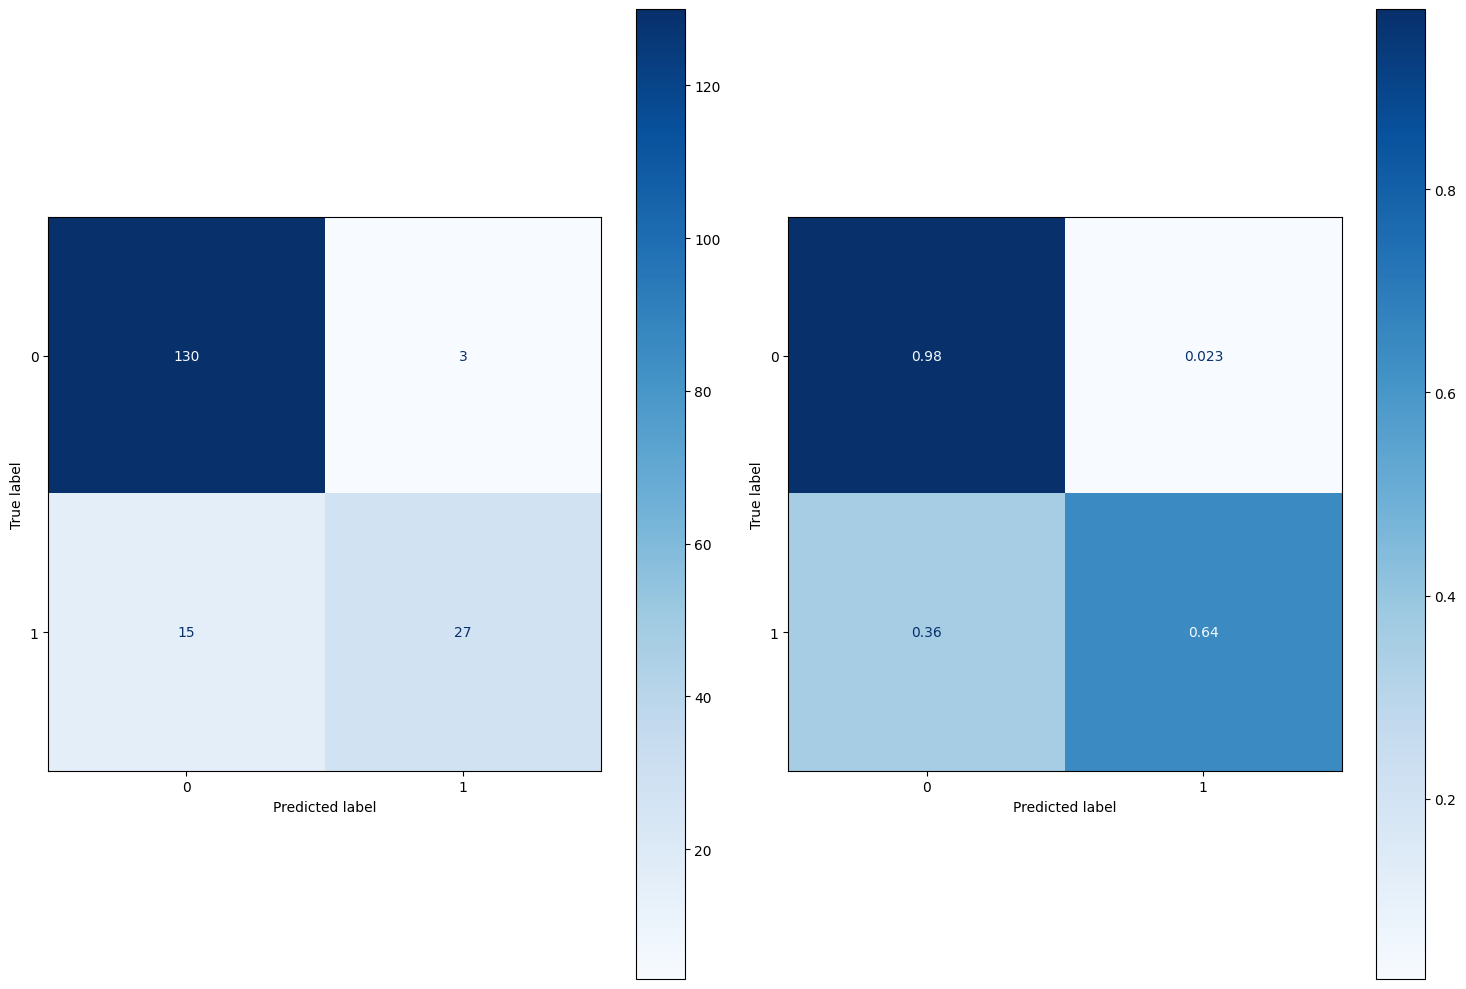

In [136]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))


ConfusionMatrixDisplay.from_predictions(y_test_grouped, pred2,ax=axes[0],
                                        cmap='Blues', normalize = None)

ConfusionMatrixDisplay.from_predictions(y_test_grouped, pred2,ax=axes[1],
                                        cmap='Blues', normalize = 'true')

plt.tight_layout()  
plt.show()
